# Intermediate Colab for TensorFlow Decision Forests

Welcome to the **Intermediate Colab** for **TensorFlow Decision Forests** (**TF-DF**) 😀.
In this colab, you will learn about some more advanced capabilities of **TF-DF**, including how to deal with natural language features.

This colab assumes you are familiar with the concepts presented the [Beginner colab](beginner_colab.ipynb), notably about the installation about TF-DF.

In this colab, we will:

1. Train a Random Forest that consumes text features natively as categorical sets.

1. Train a Random Forest that consumes text features using a [TensorFlow Hub](https://www.tensorflow.org/hub) module. In this setting (transfer learning), the module is already pre-trained on a large text corpus.

1. Train a Gradient Boosted Decision Trees (GBDT) and a Neural Network together. The GBDT will consume the output of the Neural Network.


In [ ]:
# Install TensorFlow Dececision Forests
!pip install tensorflow_decision_forests

Install [Wurlitzer](https://pypi.org/project/wurlitzer/). It can be used to show
the detailed training logs. This is only needed in colabs.

In [ ]:
!pip install wurlitzer

## Importing the libraries

In [ ]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

## Train a Random Forest on raw NLP features using the Categorical Set splitter.

TF-DF can consume [categorical-set](https://arxiv.org/pdf/2009.09991.pdf) features natively. Categorical-sets represent text features as bags of words (or n-grams).

For example: `"The little blue dog" ` → `{"the", "little", "blue", "dog"}`

In this example, we will train a Random Forest on the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/index.html) (SST) dataset. The objective of this dataset is to classify sentences as carrying a *positive* or *negative* sentiment. We will use the binary classification version of the dataset curated in [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/glue#gluesst2).

**Note:** Categorical-set features can be expensive to train. In this colab, we will train a small Random Forest with 20 trees.

In [ ]:
# Load the dataset
import tensorflow_datasets as tfds
all_ds = tfds.load("glue/sst2")

# Display the first 3 examples of the test fold.
for example in all_ds["test"].take(3):
  print({attr_name: attr_tensor.numpy() for attr_name, attr_tensor in example.items()})

{'idx': 163, 'label': -1, 'sentence': b'not even the hanson brothers can save it'}
{'idx': 131, 'label': -1, 'sentence': b'strong setup and ambitious goals fade as the film descends into unsophisticated scare tactics and b-film thuggery .'}
{'idx': 1579, 'label': -1, 'sentence': b'too timid to bring a sense of closure to an ugly chapter of the twentieth century .'}


The dataset is modified as follows:

1. The raw labels are integers in {-1, 1}, but the learning algorithm expects positive integer labels e.g. {0, 1}. Therefore, the labels are transformed as follows: `new_labels = (original_labels + 1) / 2`.
1. A batch-size of 64 is applied to make reading the dataset more efficient.
1. The `sentence` attribute needs to be tokenized, i.e. `"hello world" -> ["hello", "world"]`.


**Note:** We don't use the `test` split of the dataset as it does not have labels. If `test` split had labels, we would have concatenated the `validation` fold into the `train` one (e.g. `all_ds["train"].concatenate(all_ds["validation"])`).

**Details:** Some decision forest learning algorithms do not need a validation dataset (e.g. Random Forests) while others do (e.g. Gradient Boosted Trees in some cases). Since each learning algorithm under TF-DF can use validation data differently, TF-DF handles train/validation splits internally. As a result, when you have a training and validation sets, they can always be concatenated as input to the learning algorithm.

In [ ]:
def prepare_dataset(example):
  label = (example["label"] + 1) // 2
  return {"sentence" : tf.strings.split(example["sentence"])}, label

train_ds = all_ds["train"].batch(64).map(prepare_dataset)
test_ds = all_ds["validation"].batch(64).map(prepare_dataset)

Finaly, we train and evaluate the model as usual. TF-DF  automatically detects multi-valued categorical features as categorical-set.


In [ ]:
%output_height 300px

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(num_trees=30)

# Optionally, add evaluation metrics.
model_1.compile(metrics=["accuracy"])

# Train the model.
with sys_pipes():
  model_1.fit(x=train_ds)

I0430 10:27:36.787370 1237263 api.py:447] Collect training examples.
Features: {'sentence': tf.RaggedTensor(values=Tensor("data:0", shape=(None,), dtype=string), row_splits=Tensor("data_1:0", shape=(None,), dtype=int64))}
Label: Tensor("data_2:0", shape=(None,), dtype=int64)
I0430 10:27:36.812072 1237263 api.py:447] Normalized features: {'sentence': SemanticTensor(semantic=<Semantic.CATEGORICAL_SET: 4>, tensor=tf.RaggedTensor(values=Tensor("data:0", shape=(None,), dtype=string), row_splits=Tensor("data_1:0", shape=(None,), dtype=int64)))}
1053/1053 [==============================] - 4s 2ms/step
I0430 10:27:40.972855 1237263 kernel.cc:712] Start Yggdrasil model training
I0430 10:27:40.972951 1237263 kernel.cc:713] Collect training examples
I0430 10:27:40.972984 1237263 kernel.cc:374] Number of batches: 1053
I0430 10:27:40.973006 1237263 kernel.cc:375] Number of examples: 67349
I0430 10:27:41.010633 1237263 data_spec_inference.cc:271] 12816 item(s) have been pruned (i.e. they are conside

In the previous logs, note that `sentence` is a `CATEGORICAL_SET` feature.

The model is evaluated as usual:

In [ ]:
evaluation = model_1.evaluate(test_ds)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

14/14 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.7603
BinaryCrossentropyloss: 0.0
Accuracy: 0.7603210806846619


The training logs looks are follow:

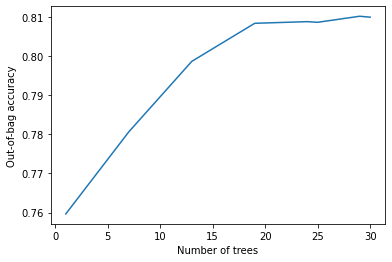

In [ ]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag accuracy")
pass

More trees would probably be beneficial (I am sure of it because I tried :p).

## Train a Random Forest able to consume NLP features using a pre-trained TensorFlow Hub module

In the previous example, we trained a Random Forest using raw text features. In the next example, we will use a pre-trained TF-Hub embedding to convert text features into a dense embedding, and then train a Random Forest on top of it. In this situation, the Random Forest will only "see" the numerical output of the embedding (i.e. it will not see the raw text). 

In this experiment,  will use the [Universal-Sentence-Encoder](https://tfhub.dev/google/universal-sentence-encoder/4). Different pre-trained embeddings might be suited for different types of text (e.g. different language, different task) but also for other type of structured features (e.g. images).

**Note:** This embedding is large (1GB) and therefore the final model will be slow to run (compared to classical decision tree inference).

The embedding module can be applied in one of two places:

1. During the dataset preparation.
2. In the pre-processing stage of the model.

The second option is often preferable: Packaging the embedding in the model makes the model easier to use (and harder to misuse :) ).

But first, let's install TF-Hub:

In [ ]:
!pip install --upgrade tensorflow-hub

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


Unlike before, we don't need to tokenize the text.

In [ ]:
def prepare_dataset(example):
  label = (example["label"] + 1) // 2
  return {"sentence" : example["sentence"]}, label

train_ds = all_ds["train"].batch(64).map(prepare_dataset)
test_ds = all_ds["validation"].batch(64).map(prepare_dataset)


In [ ]:
%output_height 300px

import tensorflow_hub as hub
embedding = hub.KerasLayer("http://tfhub.dev/google/universal-sentence-encoder/4")

# NNLM (https://tfhub.dev/google/nnlm-en-dim128/2) is also a good choice.
# embedding = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")

sentence = tf.keras.layers.Input(shape=(), name="sentence", dtype=tf.string)
embedded_sentence = embedding(sentence)

raw_inputs = {"sentence": sentence}
processed_inputs = {"embedded_sentence": embedded_sentence}
preprocessor = tf.keras.Model(inputs=raw_inputs, outputs=processed_inputs)

model_2 = tfdf.keras.RandomForestModel(
    preprocessing=preprocessor,
    num_trees=100)
model_2.compile(metrics=["accuracy"])

with sys_pipes():
  model_2.fit(x=train_ds)

I0430 10:30:20.331904 1237263 api.py:447] Collect training examples.
Features: {'sentence': <tf.Tensor 'data:0' shape=(None,) dtype=string>}
Label: Tensor("data_1:0", shape=(None,), dtype=int64)
I0430 10:30:20.388400 1237263 api.py:447] Applying preprocessing on inputs. Result: {'embedded_sentence': <tf.Tensor 'model_2/keras_layer_1/StatefulPartitionedCall:0' shape=(None, 512) dtype=float32>}
I0430 10:30:20.911289 1237263 api.py:447] Normalized features: {'embedded_sentence.0': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice:0' shape=(None,) dtype=float32>), 'embedded_sentence.1': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_1:0' shape=(None,) dtype=float32>), 'embedded_sentence.2': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_2:0' shape=(None,) dtype=float32>), 'embedded_sentence.3': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_3:0' shape=(No

In [ ]:
evaluation = model_2.evaluate(test_ds)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

14/14 [==============================] - 2s 14ms/step - loss: 0.0000e+00 - accuracy: 0.7672
BinaryCrossentropyloss: 0.0
Accuracy: 0.767201840877533


Note that categorical sets represent text differently from a dense embedding, so it may be useful to use both strategies jointly.

## Train a Gradient Boosted Decision Trees (GBDT) and a Neural Network together

In the previous example, we used a pre-trained Neural Network (NN) to 
process the text features before passing them to the Random Forest. In this example, we will train both the Neural Network and the Random Forest from scratch.

TF-DF's Decision Forests do not back-propagate gradients ([although this is the subject of ongoing research](https://arxiv.org/abs/2007.14761)). Therefore, the training happens in two stages:

1. Train the neural-network as a standard classification task:

```
example → [Normalize] → [Neural Network*] → [classification head] → prediction
*: Training.
```

2. Replace the Neural Network's head (the last layer and the soft-max) with a Random Forest. Train the Random Forest as usual:

```
example → [Normalize] → [Neural Network] → [Random Forest*] → prediction
*: Training.
```

We will use the [Palmer's Penguins](https://allisonhorst.github.io/palmerpenguins/articles/intro.html) dataset already used in the Beginner colab.

In [ ]:
# Download the dataset
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv -O /tmp/penguins.csv

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv("/tmp/penguins.csv")

# Display the first 3 examples.
dataset_df.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007


In [ ]:
# Curate the dataset
# See the beginner colab for explanations.

label = "species"

# Replaces numerical NaN (representing missing values in Pandas Dataframe) with 0s.
# ...Neural Nets don't work well with numerical NaNs.
for col in dataset_df.columns:
  if dataset_df[col].dtype not in [str, object]:
    dataset_df[col] = dataset_df[col].fillna(0)

In [ ]:
# Split the dataset into a training and testing dataset.

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

# Convert the datasets into tensorflow datasets
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

248 examples in training, 96 examples for testing.


In [ ]:
# Let's create a neural network.

# The inputs
input_1 = tf.keras.Input(shape=(1,), name="bill_length_mm", dtype="float")
input_2 = tf.keras.Input(shape=(1,), name="island", dtype="string")

# For simplicity, we only inject and prepare two input features.

nn_raw_inputs = [input_1, input_2]

# Normalization.
Normalization = tf.keras.layers.experimental.preprocessing.Normalization
CategoryEncoding = tf.keras.layers.experimental.preprocessing.CategoryEncoding
StringLookup = tf.keras.layers.experimental.preprocessing.StringLookup

values = train_ds_pd["bill_length_mm"].values
input_1_normalizer = Normalization()
input_1_normalizer.adapt(values)

values = train_ds_pd["island"].values
input_2_indexer = StringLookup(max_tokens=32)
input_2_indexer.adapt(values)

input_2_onehot = CategoryEncoding(output_mode="binary", max_tokens=32)

normalized_input_1 = input_1_normalizer(input_1)
normalized_input_2 = input_2_onehot(input_2_indexer(input_2))

nn_processed_inputs = [normalized_input_1, normalized_input_2]

# Neural network
y = tf.keras.layers.Concatenate()(nn_processed_inputs)
y = tf.keras.layers.Dense(16, activation=tf.nn.relu6)(y)
y = tf.keras.layers.Dense(8, activation=tf.nn.relu, name="last")(y)
y = tf.keras.layers.Dense(3)(y)
# "3" for the three label classes. If we have a binary classification, the
# output dim would be 1.

nn_model = tf.keras.models.Model(nn_raw_inputs, y)

In [ ]:
# Let's add a Random Forest on top of the neural network.

# Get the last hidden layer of the neural net. This is what the decision forest
# will "see".
nn_head = nn_model.get_layer("last").output

# To reduce the risk of mistakes, we group both the decision forest and the
# neural network in a single keras model.
nn_without_head = tf.keras.models.Model(inputs=nn_model.inputs, outputs=nn_head)
df_and_nn_model = tfdf.keras.RandomForestModel(preprocessing=nn_without_head)

The model will be trained in two stages: First the neural network with its own head. Then, the random forest.

In [ ]:
%output_height 300px
# Train the neural network.

nn_model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=["accuracy"])

nn_model.fit(x=train_ds, validation_data=test_ds, epochs=10)
nn_model.summary()

Epoch 1/10
4/4 [==============================] - 1s 75ms/step - loss: 1.1346 - accuracy: 0.2419 - val_loss: 1.1251 - val_accuracy: 0.2604
Epoch 2/10
4/4 [==============================] - 0s 17ms/step - loss: 1.1246 - accuracy: 0.2661 - val_loss: 1.1177 - val_accuracy: 0.2812
Epoch 3/10
4/4 [==============================] - 0s 17ms/step - loss: 1.1166 - accuracy: 0.2782 - val_loss: 1.1103 - val_accuracy: 0.2917
Epoch 4/10
4/4 [==============================] - 0s 15ms/step - loss: 1.1088 - accuracy: 0.2903 - val_loss: 1.1029 - val_accuracy: 0.2917
Epoch 5/10
4/4 [==============================] - 0s 16ms/step - loss: 1.1011 - accuracy: 0.2944 - val_loss: 1.0955 - val_accuracy: 0.2917
Epoch 6/10
4/4 [==============================] - 0s 11ms/step - loss: 1.0937 - accuracy: 0.2944 - val_loss: 1.0885 - val_accuracy: 0.2917
Epoch 7/10
4/4 [==============================] - 0s 12ms/step - loss: 1.0865 - accuracy: 0.3105 - val_loss: 1.0818 - val_accuracy: 0.2917
Epoch 8/10
4/4 [===========

/usr/local/google/_bazel_gbm/957f7e5526d4a3fbdb4405b22c6b2d1e/execroot/google3/bazel-out/k8-opt/bin/third_party/tensorflow_decision_forests/notebook.runfiles/google3/third_party/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex', 'year'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


In [ ]:
%output_height 300px
# Train the random forest.

df_and_nn_model.compile(metrics=["accuracy"])
with sys_pipes():
  df_and_nn_model.fit(x=train_ds)

I0430 10:31:37.628148 1237263 api.py:447] Collect training examples.
Features: {'island': <tf.Tensor 'data_4:0' shape=(None,) dtype=string>, 'bill_length_mm': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'bill_depth_mm': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'flipper_length_mm': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'body_mass_g': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'sex': <tf.Tensor 'data_5:0' shape=(None,) dtype=string>, 'year': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>}
Label: Tensor("data_7:0", shape=(None,), dtype=int64)
I0430 10:31:37.681892 1237263 api.py:447] Applying preprocessing on inputs. Result: Tensor("model_4/last/Relu:0", shape=(None, 8), dtype=float32)
I0430 10:31:37.734096 1237263 api.py:447] Normalized features: {'model_4/last/Relu:0.0': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice:0' shape=(None,) dtype=float32>), 'model_4/last/Relu:0.1': SemanticTensor(semantic=<Semantic.NU

We can now evaluate the composed model:

In [ ]:
print("Evaluation:", df_and_nn_model.evaluate(test_ds))

2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9583
Evaluation: [0.0, 0.9583333134651184]


and compare it to the Neural Network alone:

In [ ]:
print("Evaluation :", nn_model.evaluate(test_ds))

2/2 [==============================] - 0s 2ms/step - loss: 1.0622 - accuracy: 0.5312
Evaluation : [1.0621919631958008, 0.53125]
